In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import pickle
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Autosaving every 180 seconds


In [22]:
#load data
estimates = np.loadtxt("Ford_estimates_v2.txt")
pred_stds = np.loadtxt("Ford_pred_stds_v2.txt")
ground_truth = np.loadtxt("E:/Ford/IJRR-Dataset-1-subset/SCANS/truth.txt")
runlen = np.shape(estimates)[0]

vf = ground_truth[:runlen,0]/10
# print(vf)

# print(estimates[:,0])

<IPython.core.display.Javascript object>


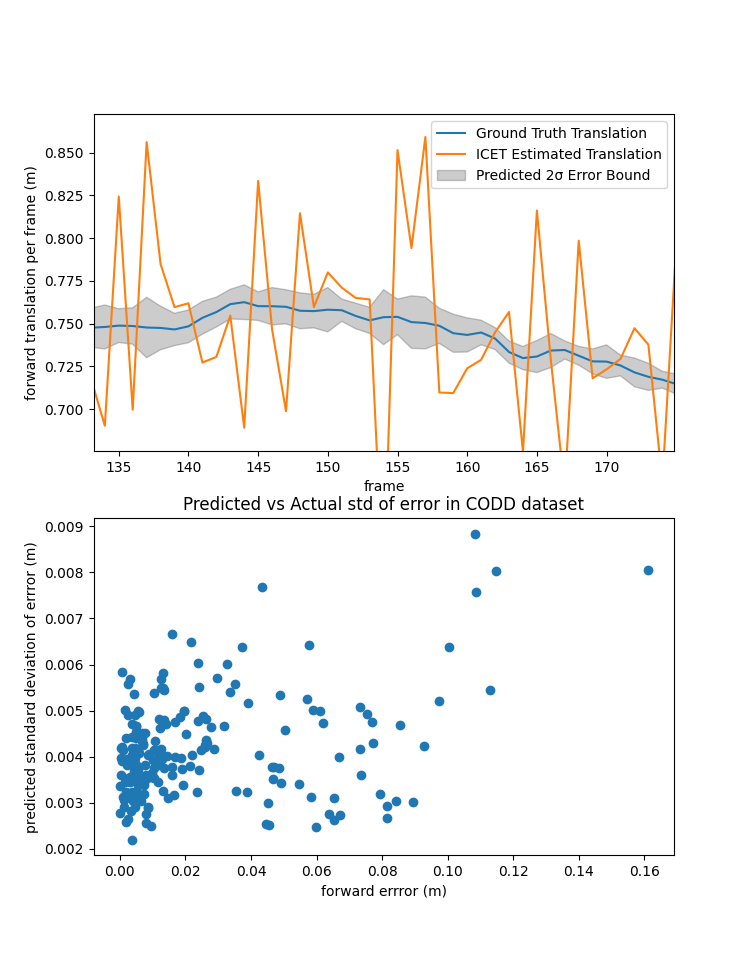

correlation: 
 [[1.         0.32646954]
 [0.32646954 1.        ]]


In [24]:
fig, ax = plt.subplots(2,1)

ax[0].plot(vf, label = 'Ground Truth Translation')

vf = vf[:runlen]

# print(estimates[:,0])
ax[0].plot(estimates[:,1], label = "ICET Estimated Translation")
# ax[0].plot(estimates[:,0] + pred_stds[:,0], color = [0,0,0], alpha = 0.1)
# ax[0].plot(estimates[:,0] - pred_stds[:,0], color = [0,0,0], alpha = 0.1)
ax[0].fill_between(np.linspace(0,runlen-1,runlen), 
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'Predicted 2σ Error Bound')
ax[0].set_xlabel("frame")
ax[0].set_ylabel("forward translation per frame (m)")
ax[0].legend(loc = 'best')
# ax[0].set_tile("Simple Outlier Rejection")

ferr = vf - estimates[:,1]
# ax[1].plot(abs(ferr))
# ax[1].plot(pred_stds[:,0])
ax[1].scatter(abs(ferr), pred_stds[:,1])
ax[1].set_xlabel("forward errror (m)")
ax[1].set_ylabel("predicted standard deviation of errror (m)")
ax[1].set_title("Predicted vs Actual std of error in CODD dataset")

#correlation between higher predicted std of error and actual higher std of error
print("correlation: \n", np.corrcoef(abs(ferr), pred_stds[:,1]))
# print(np.sum(ferr))
# print(np.sum(vf))

In [21]:
# print(vf)
# print(estimates[:,1])

d = vf - estimates[:,1]
# print(np.mean(abs(d)))